## Imports

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score,precision_score,recall_score,jaccard_score,log_loss,confusion_matrix


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

from xgboost import XGBClassifier



## Funcs

In [3]:
def cls_feature(X,max_cat = 10):
        #Agrupando features numéricas
    numeric_features  = [cls for cls in X.columns if X[cls].dtype == 'float64' or X[cls].dtype =='int64']
    # print('>>numeric_features:', numeric_features ,
          # len(numeric_features))


    #Agrupando features categoricas
    categorical_features = [cls for cls in X.columns if X[cls].dtypes == 'object' and X[cls].nunique()<=max_cat]
    # print('\n>>cat_features:', cat_features ,
          # len(cat_features))
    return numeric_features , categorical_features

In [94]:
def print_metrics(y_true, y_pred, y_pred_proba):
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    #f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred)

    print("Accuracy: {:.2f}".format(accuracy))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    #print("F1-Score: {:.2f}".format(f1))
    print("Log Loss: {:.2f}".format(logloss))
    print("ROC AUC Score: {:.2f}".format(roc_auc))

## data

In [5]:
df = pd.read_csv('data/atual_train.csv')

In [6]:
data_test = pd.read_csv('data/test.csv')

In [7]:

df

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso,cat_empresa,cat_salario,cat_experiencia
0,EZYV10567,Europa,Ensino Médio,N,S,2087,1855,Sul,69711.24,Ano,S,Negado,antiga,medio_baixo,3
1,EZYV5505,Ásia,Mestrado,S,N,5991,2003,Meio-Oeste,52931.38,Ano,S,Aprovado,nova,medio_baixo,2
2,EZYV5207,Ásia,Ensino Médio,N,N,1426,2000,Ilha,110830.21,Ano,S,Negado,nova,alto,4
3,EZYV7545,Ásia,Ensino Médio,N,N,3846,1992,Meio-Oeste,91884.68,Semana,S,Negado,intermediaria,medio_alto,4
4,EZYV16071,Ásia,Ensino Superior,S,N,3957,1949,Nordeste,138155.24,Ano,S,Aprovado,intermediaria,alto,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17831,EZYV17821,Ásia,Mestrado,S,N,95347,1995,Oeste,69692.24,Ano,S,Aprovado,intermediaria,medio_baixo,2
17832,EZYV13200,Europa,Ensino Médio,N,N,1483,1886,Sul,136237.62,Ano,S,Negado,antiga,alto,4
17833,EZYV8903,América do Norte,Mestrado,N,N,1504,2010,Nordeste,118187.30,Ano,S,Negado,nova,alto,4
17834,EZYV6163,América do Norte,Doutorado,S,N,251967,2010,Meio-Oeste,93133.40,Ano,S,Aprovado,nova,medio_alto,2


### Start


In [8]:
df['status_do_caso'].value_counts()

Aprovado    11937
Negado       5899
Name: status_do_caso, dtype: int64

In [9]:
df['status_do_caso'] = df['status_do_caso'].apply(lambda x: 1 if x == 'Aprovado' else 0)

In [10]:
df['status_do_caso'].value_counts()

1    11937
0     5899
Name: status_do_caso, dtype: int64

In [11]:
df.dtypes

id_do_caso                         object
continente                         object
educacao_do_empregado              object
tem_experiencia_de_trabalho        object
requer_treinamento_de_trabalho     object
num_de_empregados                   int64
ano_de_estabelecimento              int64
regiao_de_emprego                  object
salario_prevalecente              float64
unidade_de_salario                 object
posicao_em_tempo_integral          object
status_do_caso                      int64
cat_empresa                        object
cat_salario                        object
cat_experiencia                     int64
dtype: object

In [12]:
df['cat_experiencia'] =df['cat_experiencia'].astype('object')

In [97]:
list(df.columns)

['id_do_caso',
 'continente',
 'educacao_do_empregado',
 'tem_experiencia_de_trabalho',
 'requer_treinamento_de_trabalho',
 'num_de_empregados',
 'ano_de_estabelecimento',
 'regiao_de_emprego',
 'salario_prevalecente',
 'unidade_de_salario',
 'posicao_em_tempo_integral',
 'status_do_caso',
 'cat_empresa',
 'cat_salario',
 'cat_experiencia']

In [14]:
X = df.drop(columns=['id_do_caso','status_do_caso'])
y = df['status_do_caso']

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3,random_state=42)

## Prepro

In [16]:
numeric_features , categorical_features = cls_feature(X)

In [17]:
numeric_features

['num_de_empregados', 'ano_de_estabelecimento', 'salario_prevalecente']

In [18]:
categorical_features

['continente',
 'educacao_do_empregado',
 'tem_experiencia_de_trabalho',
 'requer_treinamento_de_trabalho',
 'regiao_de_emprego',
 'unidade_de_salario',
 'posicao_em_tempo_integral',
 'cat_empresa',
 'cat_salario',
 'cat_experiencia']

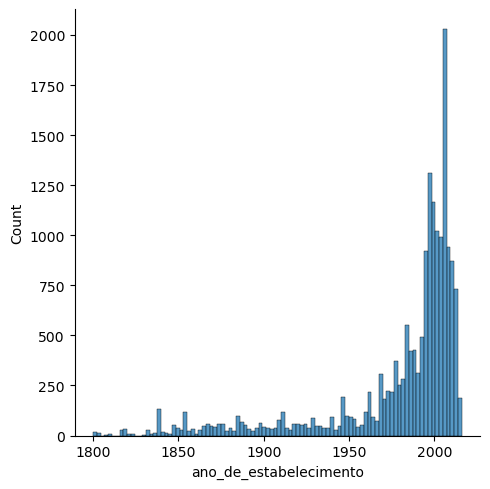

In [55]:
sns.displot(df['ano_de_estabelecimento'])

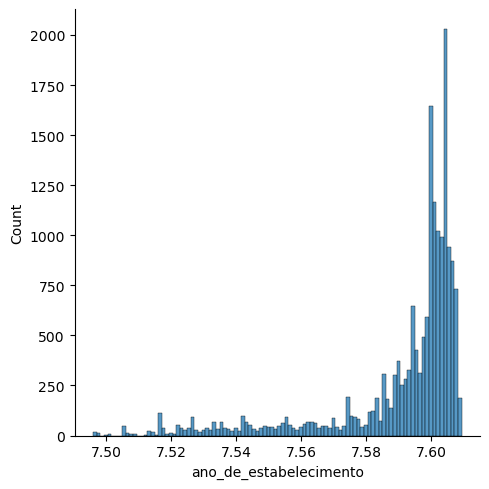

In [60]:
sns.displot(np.log1p(df['ano_de_estabelecimento']))
plt.show()

In [74]:
df['ano_de_estabelecimento'] = np.log1p(df['ano_de_estabelecimento'])

In [75]:
pipe_categorical = Pipeline([
    ('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
    ('enconder',OneHotEncoder(handle_unknown='ignore',sparse=False)),
    
])
pipe_numerical = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer([
        ("num", pipe_numerical, numeric_features),
        ("cat", pipe_categorical, categorical_features),
]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['num_de_empregados', 'ano_de_estabelecimento',
                                  'salario_prevalecente']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('enconder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['continente', 'educacao_do_empregado',
            

In [76]:
pipeline = Pipeline([
    ('preprocessor',preprocessor)   
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_de_empregados',
                                                   'ano_de_estabelecimento',
                                                   'salario_prevalecente']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')

In [77]:
X_preprocessed = pipeline.fit_transform(X)

In [ ]:
('rf_model', RandomForestClassifier(n_estimators=100,max_depth=10,random_state=0,class_weight='balanced'))


- Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
- Best RMSE for XGBoost: 0.4170148321702185

In [79]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Definir os modelos
models = {
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Definir as grades de hiperparâmetros para cada modelo
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 30],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 10]
    }
}

# Validação cruzada com 3 folds
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Treinar e ajustar os modelos
grids = {}
for model_name, model in models.items():
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, scoring='f1', n_jobs=-1, verbose=2)
    grids[model_name].fit(X_train, y_train)
    best_params = grids[model_name].best_params_
    best_score = grids[model_name].best_score_
    
    # Prever os rótulos do conjunto de teste
    y_pred = grids[model_name].predict(X_test)
    
    # Calcular o F1 score para o conjunto de teste
    f1 = f1_score(y_test, y_pred)
    
    # Imprimir os resultados
    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best F1 score for {model_name}: {best_score}')
    print(f'F1 score on test set for {model_name}: {f1}\n')

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END criterion=gini, max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END criterion=gini, max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END criterion=gini, max_depth=None, min_sa

In [80]:
clf_xgb = XGBClassifier(n_estimators=500, max_depth=3, learning_rate=0.01)

In [85]:
clf_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [92]:
y_pred = clf_xgb.predict(X_test)
y_pred_prob = clf_xgb.predict_proba(X_test)

In [30]:
from sklearn.metrics import accuracy_score


resultados = []
# Defina o número de folds
k = 5

# Crie uma instância do KFold
kf = KFold(n_splits=k, shuffle=True,random_state=42)

# Loop através dos folds
for train_index, test_index in kf.split(X):
    print('Treino:',train_index.shape[0])
    print('Validação,',test_index.shape[0])
    # Divida os dados em conjuntos de treinamento e teste
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Crie e ajuste o pipeline aos dados de treinamento
    model = pipeline.fit(X_train, y_train)
    
    # Faça as previsões nos dados de teste
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_log_proba(X_test)
    

Treino: 14268
Validação, 3568
Treino: 14269
Validação, 3567
Treino: 14269
Validação, 3567
Treino: 14269
Validação, 3567
Treino: 14269
Validação, 3567


In [25]:
print_metrics(y_test,y_pred,y_pred_proba)

Accuracy: 0.74
Precision: 0.82
Recall: 0.78
F1-Score: 0.80
Log Loss: 0.69
ROC AUC Score: 0.72


In [32]:
scores = cross_val_score(
    model,    # classificador
    X_train,          # dados treino
    y_train,          # dados teste
    cv=5,             # numero de folds
    scoring='roc_auc' # métrica avaliação
)

print("ROC_AUC score:\n", np.mean(scores))

ROC_AUC score:
 0.7781739585599946


* Random forest k =5 
- Accuracy: 0.74
- Precision: 0.82
- Recall: 0.78
- F1-Score: 0.80
- Log Loss: 0.69
- ROC AUC Score: 0.72

In [59]:
#pipeline.fit(X_train,y_train)

In [60]:
#y_pred = pipeline.predict(X_valid)
#y_pred_proba = pipeline.predict_log_proba(X_valid)

 - Primeiras metricas - Random forest trantestsplit
 - Accuracy: 0.73
 - Precision: 0.82
 - Recall: 0.77
 - F1-Score: 0.79
 - Log Loss: 0.69
 - ROC AUC Score: 0.70

## Submission

In [42]:
data_test

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral
0,EZYV22339,Ásia,Ensino Superior,S,N,2414,1973,Nordeste,103320.800,Ano,N
1,EZYV9333,Ásia,Mestrado,N,S,2928,1937,Oeste,49786.350,Ano,S
2,EZYV9740,Ásia,Ensino Superior,S,N,1836,1999,Oeste,60855.830,Ano,S
3,EZYV3328,Ásia,Ensino Superior,S,N,122,2004,Sul,82379.060,Semana,S
4,EZYV12321,América do Sul,Ensino Superior,S,S,1720,2003,Nordeste,6719.810,Ano,S
...,...,...,...,...,...,...,...,...,...,...,...
7639,EZYV19907,América do Norte,Ensino Superior,N,N,66,2008,Oeste,70.599,Hora,S
7640,EZYV576,Ásia,Ensino Médio,S,N,4040,1994,Meio-Oeste,60158.590,Ano,S
7641,EZYV1804,Ásia,Mestrado,S,N,32503,1925,Sul,44555.120,Ano,S
7642,EZYV13543,América do Norte,Mestrado,S,N,1894,2000,Sul,97830.730,Ano,S


In [44]:
sub = pd.read_csv('submission.csv')

In [45]:
sub

,id_do_caso,status_do_caso
0,EZYV22339,0
1,EZYV9333,0
2,EZYV9740,0
3,EZYV3328,0
4,EZYV12321,0
...,...,...
7639,EZYV19907,1
7640,EZYV576,0
7641,EZYV1804,0
7642,EZYV13543,0


In [47]:
len(y_pred)

5351